In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Original

In [2]:
def score_sequence(mol):
    """Return (penalized_score, raw_survivors_in_region)."""
    
    n_x, n_y, n_z, is_lost = mol[:, 0], mol[:, 1], mol[:, 2], mol[:, 5]
    mask = (is_lost == 0) & (n_x == 0) & (n_y == 0) & (n_z == 0)
    raw = int(cp.count_nonzero(mask).get())
    return raw

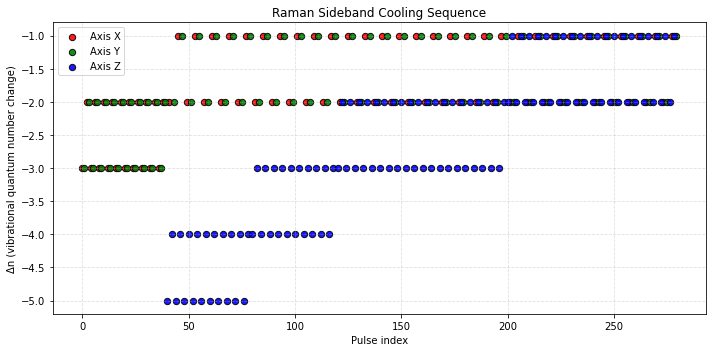

In [3]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks

# Repeat each block along the first axis, then concatenate in order
blocks = [
    cp.tile(original_gpu[0], (10, 1)),  
    cp.tile(original_gpu[1], (5, 1)),  
    cp.tile(original_gpu[2], (5, 1)),  
    cp.tile(original_gpu[3], (10, 1)),  
    cp.tile(original_gpu[4], (10, 1)),  
]

seq_gpu = cp.concatenate(blocks, axis=0)
cr.visualize_sequence(seq_gpu)

In [4]:
np.save("all_original.npy", cp.asarray(seq_gpu))

Raman pulses: 100%|██████████| 280/280 [00:45<00:00,  6.15it/s]


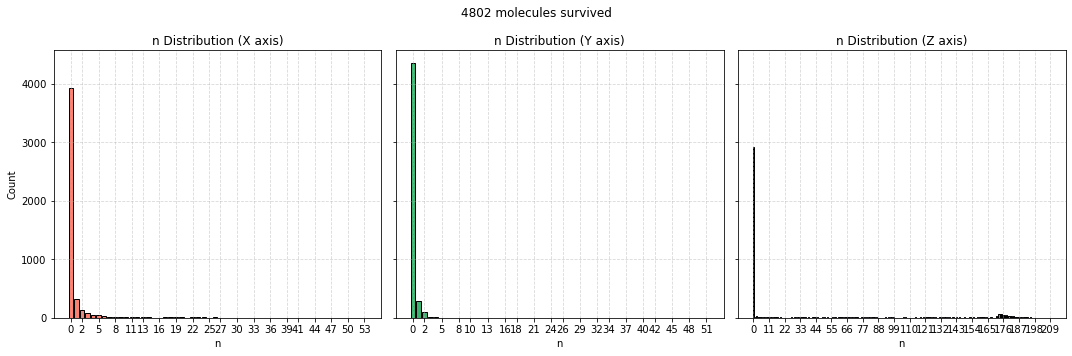

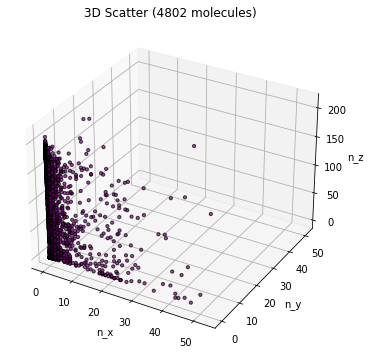

survival_rate_mean 0.4802
mot_mean [ 1.0876718   0.2209496  45.16618076]
mot_sem [0.00191834 0.00073933 0.03101611]


In [5]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_0, seq_gpu, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [7]:
score_sequence(mol_0)

2833

#### Optimized

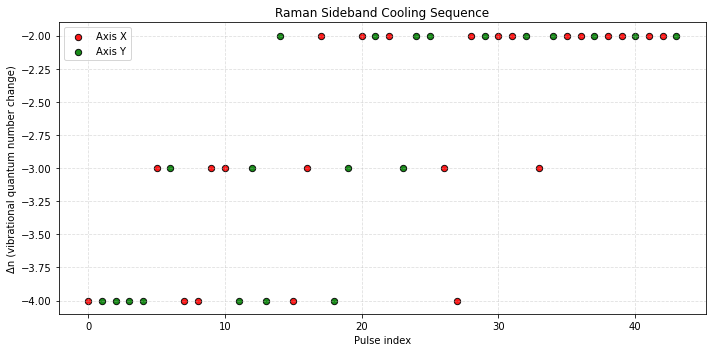

In [4]:
seq_op = cp.array(np.load("ga_runs/XY_20251027_170359/gen_039/top1_sequence.npy"))
cr.visualize_sequence(seq_op)

Raman pulses: 100%|██████████| 44/44 [00:08<00:00,  5.44it/s]


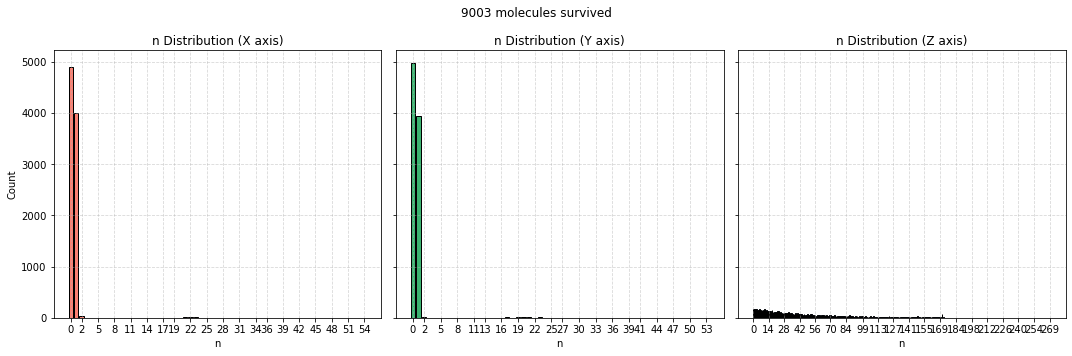

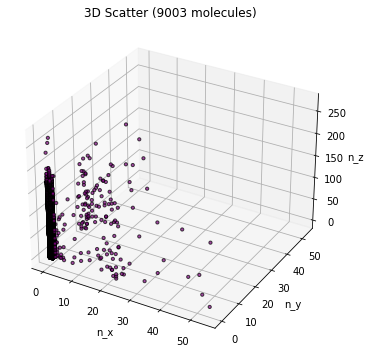

survival_rate_mean 0.9003
mot_mean [ 0.63923137  0.63112296 47.96667777]
mot_sem [0.0007552  0.000754   0.01466559]


In [4]:
temp = [25e-6, 25e-6, 25e-6]
mol_1 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_1, seq_op, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_1, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_1)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [5]:
score_sequence(mol_1)

8466

In [6]:
cr.save_molecules(mol_1, "mol_post_XY.npy")

[✓] Molecules saved to: C:\Users\LyuQi\Documents\optimize_sequence\XY\mol_post_XY.npy  (shape=(10000, 6))
